<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Practice day #1: ES models

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h1 align="center">Info</h1> 

This practice task is desinged for impriving knowledge of ES models and getting aqcuainted with time series analysis (with python pandas).

The task should take about 3-5 hours to be completed.

<h1 align="center">1. Reading data (10%)</h1>

  * Download data for following data sets
     - 1) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv </span>(1 TS of monthly wage in Russia)
     - 2) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep36.csv</span> (105 TS of goods sales in shop #36 of one real Retail Net, each TS correspond to an item in shop )
     - 3) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep42.csv</span> (105 TS of goods sales in shop #42 of one real Retail Net, each TS correspond to an item in shop)
     - 4) <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">TS_dep6.csv </span>(110 TS of goods sales in shop #6 of one real Retail Net, each TS correspond to an item in shop)
 
 All data you can find by <a href='https://1drv.ms/f/s!AqGgzb5T4tvShZ1-xS0s6FhP5x-05g'>link</a> 
 
 
 * For each data set: 
      - 1) learn it's structure in csv-file and read it into Pandas data frame (be careful with parsing data)
      - 2) plot time series (for data sets with a lot of TS you need to plot integral sales of all items in shop)
      - 3) answer the questions: is there seasonlaity, trend, changes in level in TS? If there is seasonality then define period of seasonality. 

In [1]:
# start with this code
import pandas as pd
import numpy as np
from utils import qualityRMSE, qualityMedianAE, qualityMACAPE
# from utils import ExponentialSmoothing
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt

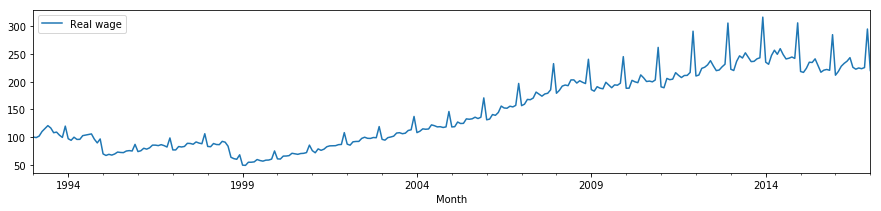

In [2]:
%matplotlib inline


ts_wage = pd.read_csv('./data/monthly-wage.csv', sep=';', decimal='.', index_col="Month", parse_dates=True, dayfirst=True)
ts_dep36 = pd.read_csv('./data/TS_dep36.csv', sep=';', decimal='.', index_col="Timestamp", parse_dates=True, dayfirst=True)
ts_dep42 = pd.read_csv('./data/TS_dep42.csv', sep=';', decimal='.', index_col="Timestamp", parse_dates=True, dayfirst=True)
ts_dep6 = pd.read_csv('./data/TS_dep6.csv', sep=';', decimal='.', index_col="Timestamp", parse_dates=True, dayfirst=True)

# Put your code below
ts_wage.plot(figsize=(15,3))

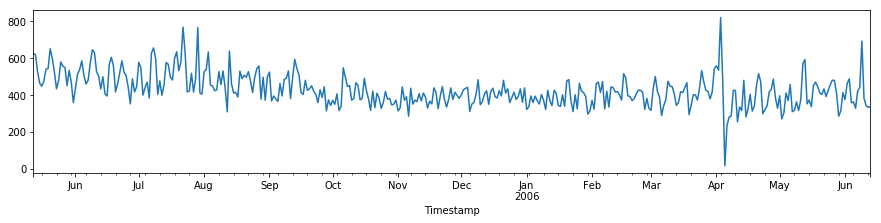

In [3]:
ts_dep36.sum(axis=1).plot(figsize=(15,3))

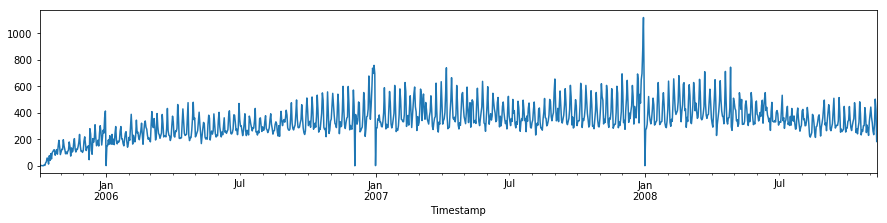

In [4]:
ts_dep42.sum(axis=1).plot(figsize=(15,3))

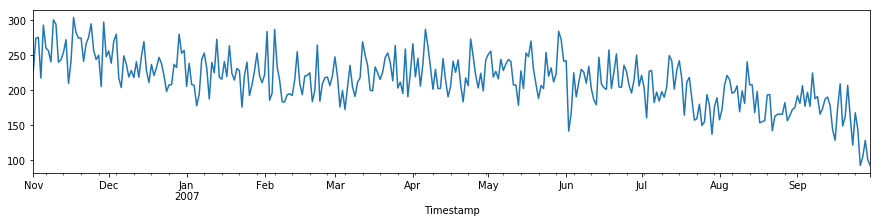

In [5]:
ts_dep6.sum(axis=1).plot(figsize=(15,3))

<h1 align="center">2. Apply Simple ES to data with trend and Seasonality (15%) </h1>
You need to apply SES (IES see seminar 2) model for TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

 * 1) Find the best param $\alpha$ of SES for data period from 09.1998 to 01.2015. Is the optimal value close to 0 or 1? (You can choose any loss function from seminar 2).
 * 2) Draw forecast with optimial value $\alpha$ for data from 09.1998 to 01.2017. Conclude whether SES can be used for this TS? If can not than explain why.
 * 3) Calculate accuracy of the forecast of TS in [02.2016, 01.2017].
 * 4) Aggregate original TS by Years (time step chould be 1 year). Repeat point 1)-2) for aggregated TS.

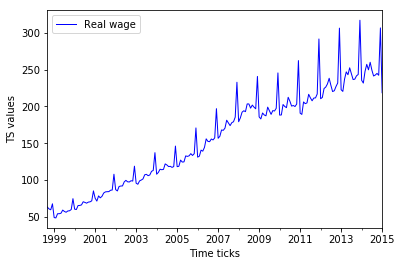

In [6]:
# put your code here
h = 1
ts_wage.ix['1998-09-01':'2015-01-01'].plot(style='b', linewidth=1.0)
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [7]:
def empty_frc(data, h):
    start = data.index[-1]+timedelta(1)
    end = data.index[-1]+timedelta(h)
    rng = pd.date_range(start, end)
    frc_ts = pd.DataFrame(index = data.index.append(rng), columns = data.columns)
    return frc_ts

In [8]:
def ExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    AdaptationPeriod=Params['AdaptationPeriod']
    FORECAST = [np.NaN]*(T+h)
    if alpha>1:
        w.warn('Alpha can not be more than 1')
        #alpha = 1
        return FORECAST
    if alpha<0:
        w.warn('Alpha can not be less than 0')
        #alpha = 0
        return FORECAST
    y = x[0]
    t0=0
    for t in range(0, T):
        if not math.isnan(x[t]):
            if math.isnan(y):
                y=x[t]
                t0=t
            if (t-t0+1)<AdaptationPeriod:
                y = y*(1-alpha*(t-t0+1)/(AdaptationPeriod)) + alpha*(t-t0+1)/(AdaptationPeriod)*x[t]
            y = y*(1-alpha) + alpha*x[t]
            #else do not nothing
        FORECAST[t+h] = y
    return FORECAST	

In [9]:
frc_ts_wage = empty_frc(ts_wage.ix['1998-09-01':'2015-01-01'], h)

In [10]:
ALPHA = [i*0.02 for i in range(51)]
alpha_opt = 0
loss_opt = 1e4
for alpha in ALPHA:
    Params = {'alpha': alpha, 'AdaptationPeriod' : 12}
    frc_ts_wage['Real wage'] = ExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'], h, Params)
    
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'],frc_ts_wage['Real wage'])
    if loss< loss_opt:
        alpha_opt = alpha
        loss_opt = loss

print("Optimal alpha = {}, Loss :{}, ".format(alpha_opt,loss_opt))

Optimal alpha = 0.24, Loss :16.326067227055635, 


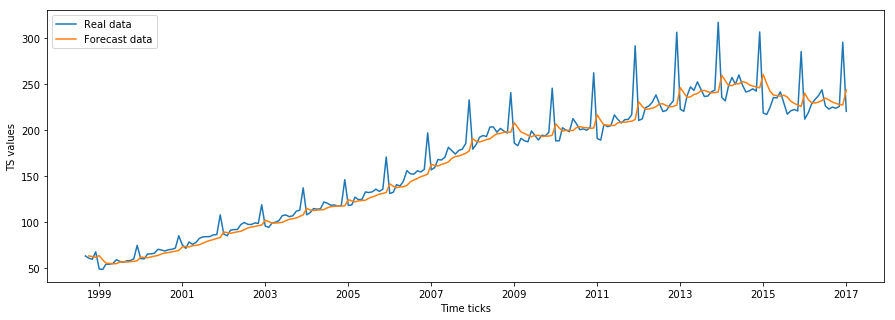

In [11]:
frc_ts_wage_optimal = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
#Draw real time series and forecasted with optimal alpha 
Params = {'alpha': alpha_opt, 'AdaptationPeriod' : 12}
frc_ts_wage_optimal['Real wage'] = ExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(frc_ts_wage_optimal.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

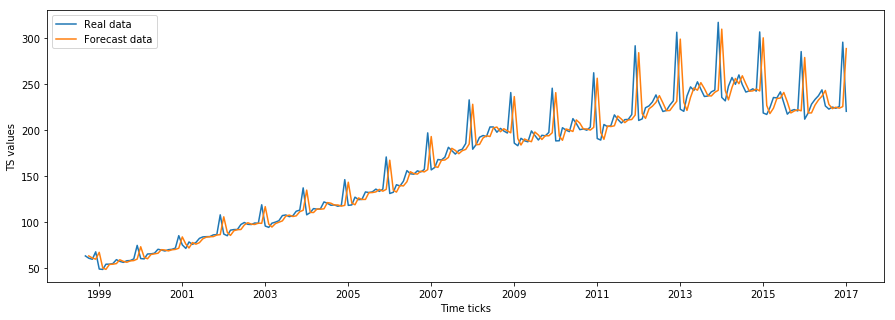

In [12]:
frc_ts_wage_similar = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
#Draw real time series and forecasted with alpha to make as similar as possible 
Params = {'alpha': 0.9, 'AdaptationPeriod' : 12}
frc_ts_wage_similar['Real wage'] = ExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(frc_ts_wage_similar.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [13]:
#calculate accuracy for both similar and optimal time series
loss_optimal, _ = qualityMACAPE(ts_wage['Real wage'].ix['2016-01-01':'2017-01-01'],frc_ts_wage_optimal['Real wage'].ix['2016-01-01':'2017-01-01'])
loss_similar, _ = qualityMACAPE(ts_wage['Real wage'].ix['2016-01-01':'2017-01-01'],frc_ts_wage_similar['Real wage'].ix['2016-01-01':'2017-01-01'])

accuracy_optimal = 1 - loss_optimal
accuracy_similar = 1 - loss_similar
print('Optimal accuracy = {:0.2f}%, Similar accuracy = {:0.2f}%'.format(accuracy_optimal*100, accuracy_similar*100))

Optimal accuracy = 93.92%, Similar accuracy = 91.99%


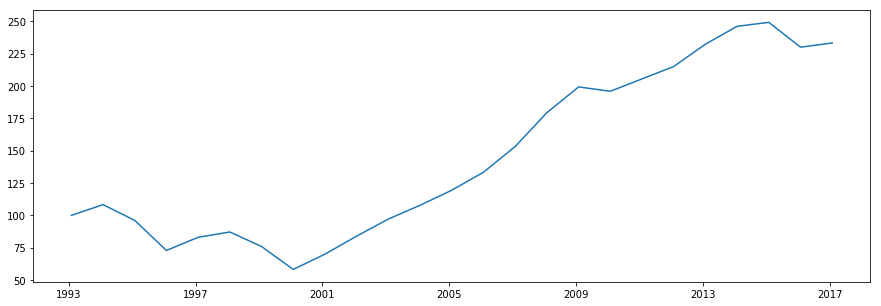

In [14]:
ts_wage_aggregated = ts_wage.resample('12M').mean()
plt.figure(figsize=(15,5))
plt.plot(ts_wage_aggregated)

In [15]:
frc_ts_wage_aggregated = empty_frc(ts_wage.ix['1998-09-01':'2015-01-01'], h)

ALPHA = [i*0.02 for i in range(51)]
alpha_opt = 0
loss_opt = 1e4
for alpha in ALPHA:
    Params = {'alpha': alpha, 'AdaptationPeriod' : 12}
    frc_ts_wage_aggregated['Real wage'] = ExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'], h, Params)
    
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'],frc_ts_wage_aggregated['Real wage'])
    
    if loss < loss_opt:
        alpha_opt = alpha
        loss_opt = loss

print("Optimal alpha = {}, Loss :{}, ".format(alpha_opt,loss_opt))

Optimal alpha = 0.24, Loss :16.326067227055635, 


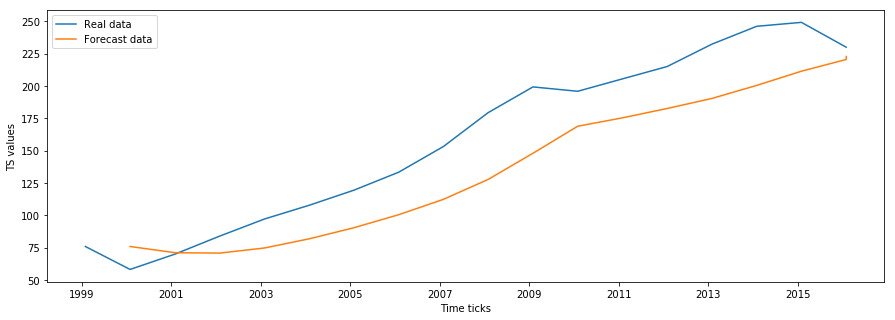

In [16]:
frc_ts_wage_aggregated_optimal = empty_frc(ts_wage_aggregated.ix['1998-09-01':'2017-01-01'], h)
#Draw real time series and forecasted with optimal alpha 
Params = {'alpha': alpha_opt, 'AdaptationPeriod' : 12}
frc_ts_wage_aggregated_optimal['Real wage'] = ExponentialSmoothing(ts_wage_aggregated['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage_aggregated.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(frc_ts_wage_aggregated_optimal.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

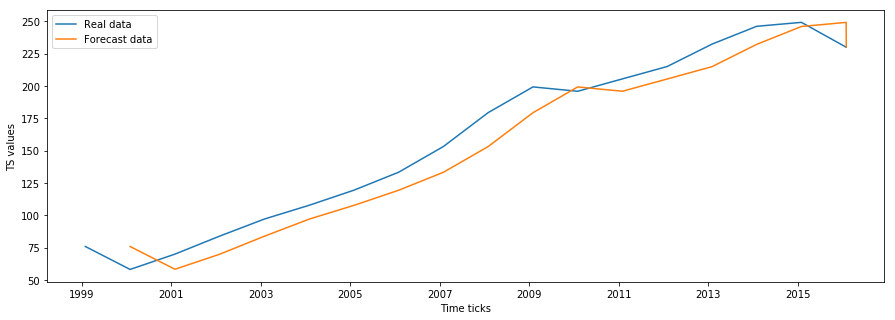

In [17]:
frc_ts_wage_aggregated_similar = empty_frc(ts_wage_aggregated.ix['1998-09-01':'2017-01-01'], h)
#Draw real time series and forecasted with optimal alpha 
Params = {'alpha': 0.99, 'AdaptationPeriod' : 12}
frc_ts_wage_aggregated_similar['Real wage'] = ExponentialSmoothing(ts_wage_aggregated['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage_aggregated.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(frc_ts_wage_aggregated_similar.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

<h1 align="center">3. Winters model for Additive Seasonality (25%) </h1>
You need to realize ES model for TS with additive seasonality and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Winters model for Seasonal TS (use code from seminar 2 as example)
* 2) Find optimal params $\alpha$ (smoothing of level) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values $\alpha$ and $\gamma$ from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2016, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of SES: is it better? 
* \*5) Conclude whether Winter's ES can be used for this TS?

In [18]:
# Start with this code
###################### Winters Exponential Smoothing #########################
# x <array Tx1>- time series, 
# h <scalar> - forecasting delay
# Params <dict> - dictionary with 
#    alpha <scalar in [0,1]> - smoothing parameter
#    delts <scalar in [0,1]> - seasonality smoothing parameter

def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    gamma = Params['gamma']
    p = Params['seasonality_period']

    
    FORECAST = [np.NaN]*(T+h)
    
    if alpha>1 or gamma>1:
        w.warn('Alpha or Gamma are bigger than 1')
        return FORECAST

    if alpha<0 or gamma<0:
        w.warn('Alpha or Gamma are less than 0')
        return FORECAST
    
    l= np.mean(x[:p]) 
    s= x[:p] - l
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l= np.mean(x[t:t+p])
                
            if math.isnan(s[cntr % p]):
                s[cntr % p] = x[cntr] - l
    
            s[cntr % p] = gamma*(x[cntr] - l) + (1 - gamma)*s[cntr % p]
            l = alpha*(x[cntr]-s[cntr % p]) + (1 - alpha)*l 
            
        FORECAST[cntr+h] = l + s[(cntr+h) % p]
    return FORECAST

In [19]:
h = 1
w_frc_ts_wage = empty_frc(ts_wage.ix['1998-09-01':'2015-01-01'], h)

In [20]:
ALPHA = [i*0.02 for i in range(51)]
GAMMA = [i*0.02 for i in range(51)]

alpha_opt = 0
gamma_opt = 0
loss_opt = 1e4

for alpha in ALPHA:
    for gamma in GAMMA:
        Params = {'alpha': alpha, 'gamma': gamma,'seasonality_period' : 12}
        w_frc_ts_wage['Real wage'] = WintersExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'], h, Params)

        loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'],w_frc_ts_wage['Real wage'])

        if loss < loss_opt:
            alpha_opt = alpha
            gamma_opt = gamma
            loss_opt = loss

print("Optimal alpha = {}, gamma = {}, Loss :{}, ".format(alpha_opt, gamma_opt, loss_opt))

Optimal alpha = 1.0, gamma = 0.48, Loss :4.54596518754635, 


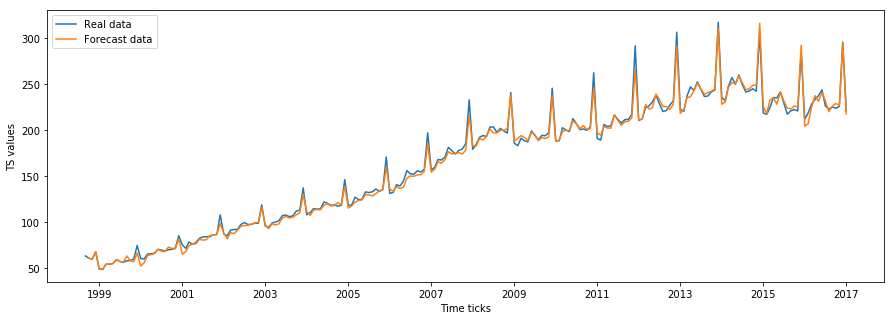

In [21]:
w_frc_ts_wage_optimal = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
Params = {'alpha': alpha_opt, 'gamma': gamma_opt,'seasonality_period' : 12}
w_frc_ts_wage_optimal['Real wage'] = WintersExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(w_frc_ts_wage_optimal.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [22]:
loss, _ = qualityMACAPE(ts_wage['Real wage'].ix['2016-01-01':'2017-01-01'],w_frc_ts_wage_optimal['Real wage'].ix['2016-01-01':'2017-01-01'])

accuracy = 1 - loss

print('Accuracy = {:0.2f}%'.format(accuracy*100))

Accuracy = 98.09%


<h2 align="left">4. Theil-Wage model for TS with linear trend and seasonality (25%)</h2>
You need to realize Theil-Wage model and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize Theil-Wage model for (use code from seminar 2 as example)
* 2) Find optimal params $\alpha$ (smoothing of level), $\beta$ (smoothing trend) and $\gamma$ (smoothing of seasonality) (use data from 09.1998 to 01.2015).(Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values $\alpha$, $\beta$ and $\gamma$ from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2016, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model: is it better than the last one? 
* \*5) Suggest how can the Theil-Wage model be improved to make accuracy of forecast better?

In [23]:
def TheilWageExponentialSmoothing(x, h, Params):
    x = np.array(x)
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
   
    FORECAST = [np.NaN]*(T+h)
    
    if alpha > 1 or beta > 1 or gamma > 1:
        w.warn('Alpha or Gamma or Beta are bigger than 1')
        return FORECAST

    if alpha < 0 or beta < 0 or gamma < 0:
        w.warn('Alpha or Gamma or Beta are less than 0')
        return FORECAST
    
    l = np.mean(x[:p])
    b = np.mean(x[p:2*p] - x[:p])/p
    s = x[:p] - l
       
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = np.mean(x[cntr:cntr+p])
            if math.isnan(b):
                b = np.mean(x[cntr+p:cntr+2*p] - x[cntr:cntr+p])/p
            if math.isnan(s[cntr % p]):
                s[cntr % p] = x[cntr] - l

            s[cntr % p] = gamma*(x[cntr] - l - b) + (1-gamma)*s[cntr % p] 

            l_prev = l
            l = alpha*(x[cntr] - s[cntr % p]) + (1-alpha)*(l+b)
            b = beta*(l - l_prev) + (1-beta)*b

        FORECAST[cntr+h] = l + h*b + s[(cntr+h) % p]
    return FORECAST

In [24]:
h = 1
tw_frc_ts_wage = empty_frc(ts_wage.ix['1998-09-01':'2015-01-01'], h)

In [25]:
ALPHA = [i*0.02 for i in range(51)]
BETA = [i*0.02 for i in range(51)]
GAMMA = [i*0.02 for i in range(51)]

alpha_opt = 0
beta_opt = 0
gamma_opt = 0
loss_opt = 1e4

for alpha in ALPHA:
    for beta in BETA:
        for gamma in GAMMA:
            Params = {'alpha': alpha, 'beta': beta, 'gamma': gamma,'seasonality_period' : 12}
            tw_frc_ts_wage['Real wage'] = TheilWageExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'], h, Params)
            
            loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'],tw_frc_ts_wage['Real wage'])
            if loss < loss_opt:
                alpha_opt = alpha
                beta_opt = beta
                gamma_opt = gamma
                loss_opt = loss

print("Optimal alpha = {}, beta = {}, gamma = {}, Loss :{}, ".format(alpha_opt, beta_opt, gamma_opt, loss_opt))

Optimal alpha = 1.0, beta = 0.02, gamma = 0.56, Loss :4.236542586982742, 


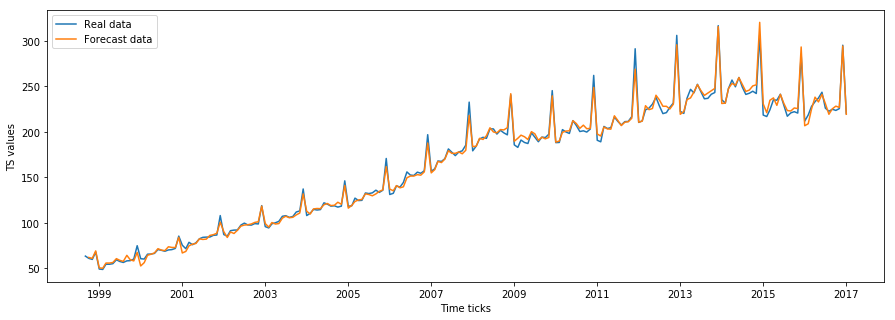

In [26]:
tw_frc_ts_wage_optimal = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
Params = {'alpha': alpha_opt, 'beta': beta_opt, 'gamma': gamma_opt,'seasonality_period' : 12}
tw_frc_ts_wage_optimal['Real wage'] = TheilWageExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(tw_frc_ts_wage_optimal.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [27]:
loss, _ = qualityMACAPE(ts_wage['Real wage'].ix['2016-01-01':'2017-01-01'],tw_frc_ts_wage_optimal['Real wage'].ix['2016-01-01':'2017-01-01'])

accuracy = 1 - loss

print('Accuracy = {:0.2f}%'.format(accuracy*100))

Accuracy = 98.42%


<h2 align="left"> 5. Non-additive model of ES (25%)</h2>
You need to realize some ES-model that include non-addive component (or multiplicative trend or multiplicative component) and then use it for forecasting real TS <span style="color:blue; font-family:'New Times Roman'; font-size:14pt">monthly-wage.csv</span>.

Forecast delay $h=1$ for all point in this task.

* 1) Realize one of following ES models: ESM(A,M) (t.e. Holt-Winters model), ESM(Ad,M), ESM(M,A), ESM(M,M) model.
* 2) Find optimal params of the model (use data from 09.1998 to 01.2015). Note: if you choose damped trend model that $\phi$ you can just set it expetrly (say $0.98$). (Loss function should be the same as in task 2.)
* 3) Draw forecast with optimal values of it's params from 09.1998 to 01.2017. 
* 4) Calculate accuracy of the forecast of TS in [02.2016, 01.2017] (Loss function should be the same as in task 2.). Compare it with accuracy of Winters model and Theil-Wage model: is it better than the last one? 
* 5) Is it true that multiplicative model are more unstable than additive? Unstable means thet forecast is can diver

In [28]:
def HoltWintersMultipicative(x, h, Params):
    x = np.array(x)
    T = len(x)
    alpha = Params['alpha']
    beta = Params['beta']
    gamma = Params['gamma']
    p = Params['seasonality_period']
   
    FORECAST = [np.NaN]*(T+h)
    
    if alpha > 1 or beta > 1 or gamma > 1:
        w.warn('Alpha or Gamma or Beta are bigger than 1')
        return FORECAST

    if alpha < 0 or beta < 0 or gamma < 0:
        w.warn('Alpha or Gamma or Beta are less than 0')
        return FORECAST
    
    l = np.mean(x[:p])
    b = np.mean(x[p:2*p] - x[:p])/p
    s = x[:p]/l
       
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = np.mean(x[cntr:cntr+p])
            if math.isnan(b):
                b = np.mean(x[cntr+p:cntr+2*p] - x[cntr:cntr+p])/p
            if math.isnan(s[cntr % p]):
                s[cntr % p] = x[cntr]/l

            s[cntr % p] = gamma*x[cntr]/(l - b) + (1-gamma)*s[cntr % p] 

            l_prev = l
            l = alpha * x[cntr] / s[cntr % p] + (1-alpha)*(l+b)
            b = beta*(l - l_prev) + (1-beta)*b

        FORECAST[cntr+h] = (l + h*b)*s[(cntr+h) % p]
    return FORECAST

In [29]:
h = 1
hwM_frc_ts_wage = empty_frc(ts_wage.ix['1998-09-01':'2015-01-01'], h)

In [30]:
ALPHA = [i*0.02 for i in range(51)]
BETA = [i*0.02 for i in range(51)]
GAMMA = [i*0.02 for i in range(51)]

alpha_opt = 0
beta_opt = 0
gamma_opt = 0
loss_opt = 1e4

for alpha in ALPHA:
    for beta in BETA:
        for gamma in GAMMA:
            Params = {'alpha': alpha, 'beta': beta, 'gamma': gamma,'seasonality_period' : 12}
            hwM_frc_ts_wage['Real wage'] = HoltWintersMultipicative(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'], h, Params)
            
            loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2015-01-01'],hwM_frc_ts_wage['Real wage'])
            if loss < loss_opt:
                alpha_opt = alpha
                beta_opt = beta
                gamma_opt = gamma
                loss_opt = loss

print("Optimal alpha = {}, beta = {}, gamma = {}, Loss :{}, ".format(alpha_opt, beta_opt, gamma_opt, loss_opt))

Optimal alpha = 0.88, beta = 0.62, gamma = 0.36, Loss :3.6600856416645207, 


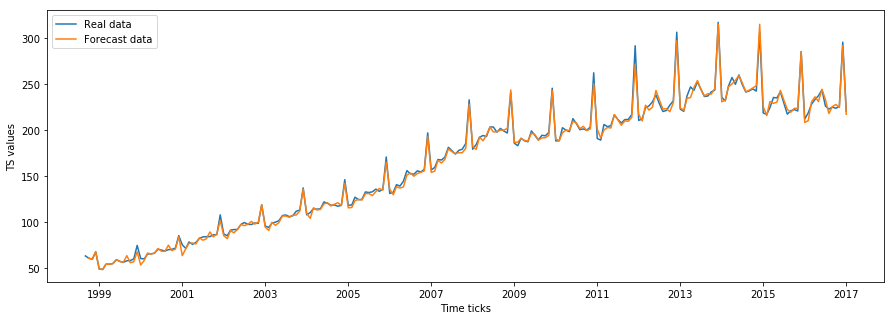

In [31]:
hwM_frc_ts_wage_optimal = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
Params = {'alpha': alpha_opt, 'beta': beta_opt, 'gamma': gamma_opt,'seasonality_period' : 12}
hwM_frc_ts_wage_optimal['Real wage'] = HoltWintersMultipicative(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params)

plt.figure(figsize=(15,5))
plt.plot(ts_wage.ix['1998-09-01':'2017-01-01'], label='Real data')
plt.plot(hwM_frc_ts_wage_optimal.ix['1998-09-01':'2017-01-01'], label='Forecast data')
plt.xlabel("Time ticks")
plt.ylabel("TS values")
plt.legend()

In [32]:
loss, _ = qualityMACAPE(ts_wage['Real wage'].ix['2016-01-01':'2017-01-01'],hwM_frc_ts_wage_optimal['Real wage'].ix['2016-01-01':'2017-01-01'])

accuracy = 1 - loss

print('Accuracy = {:0.2f}%'.format(accuracy*100))

Accuracy = 98.35%


In [33]:
#UNSTABILITY ALPHA
ALPHA = [i*0.02 for i in range(51)]

beta_opt_add = 0.02
gamma_opt_add = 0.56

beta_opt_mult = 0.58
gamma_opt_mult = 0.56

loss_add = []
loss_mult = []

hwM_frc_ts_wage_stable = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
tw_frc_ts_wage_stable = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)

for alpha in ALPHA:
    Params_add = {'alpha': alpha, 'beta': beta_opt_add, 'gamma': gamma_opt_add,'seasonality_period' : 12}
    Params_mult = {'alpha': alpha, 'beta': beta_opt_mult, 'gamma': gamma_opt_mult,'seasonality_period' : 12}

    tw_frc_ts_wage_stable['Real wage'] = TheilWageExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params_add)
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'],tw_frc_ts_wage_stable['Real wage'])
    loss_add.append(loss)

    hwM_frc_ts_wage_stable['Real wage'] = HoltWintersMultipicative(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params_mult)
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'],hwM_frc_ts_wage_stable['Real wage'])
    loss_mult.append(loss)
    

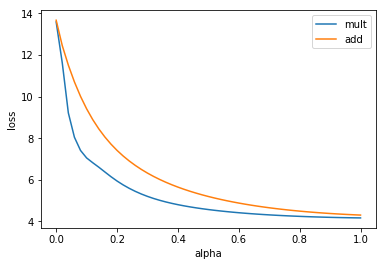

In [34]:
plt.plot(ALPHA, loss_mult, label = 'mult')
plt.plot(ALPHA, loss_add, label = 'add')
plt.xlabel("alpha")
plt.ylabel("loss")
plt.legend()

In [35]:
#UNSTABILITY BETA
BETA = [i*0.02 for i in range(51)]

alpha_opt_add = 1.0
gamma_opt_add = 0.56

alpha_opt_mult = 0.24
gamma_opt_mult = 0.56

loss_add = []
loss_mult = []

hwM_frc_ts_wage_stable = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
tw_frc_ts_wage_stable = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)

for beta in BETA:
    Params_add = {'alpha': alpha_opt_add, 'beta': beta, 'gamma': gamma_opt_add,'seasonality_period' : 12}
    Params_mult = {'alpha': alpha_opt_mult, 'beta': beta, 'gamma': gamma_opt_mult,'seasonality_period' : 12}

    tw_frc_ts_wage_stable['Real wage'] = TheilWageExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params_add)
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'],tw_frc_ts_wage_stable['Real wage'])
    loss_add.append(loss)

    hwM_frc_ts_wage_stable['Real wage'] = HoltWintersMultipicative(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params_mult)
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'],hwM_frc_ts_wage_stable['Real wage'])
    loss_mult.append(loss)
    

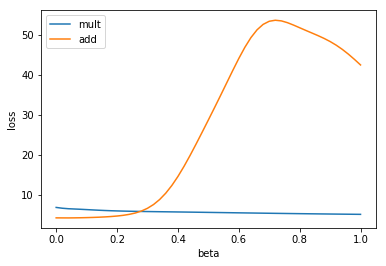

In [36]:
plt.plot(BETA, loss_mult, label = 'mult')
plt.plot(BETA, loss_add, label = 'add')
plt.xlabel("beta")
plt.ylabel("loss")
plt.legend()

In [37]:
#UNSTABILITY GAMMA
GAMMA = [i*0.02 for i in range(51)]

alpha_opt_add = 1.0
beta_opt_add = 0.02

alpha_opt_mult = 0.58
beta_opt_mult = 0.24

loss_add = []
loss_mult = []

hwM_frc_ts_wage_stable = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)
tw_frc_ts_wage_stable = empty_frc(ts_wage.ix['1998-09-01':'2017-01-01'], h)

for gamma in GAMMA:
    Params_add = {'alpha': alpha_opt_add, 'beta': beta_opt_add, 'gamma': gamma,'seasonality_period' : 12}
    Params_mult = {'alpha': alpha_opt_mult, 'beta': beta_opt_mult, 'gamma': gamma,'seasonality_period' : 12}

    tw_frc_ts_wage_stable['Real wage'] = TheilWageExponentialSmoothing(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params_add)
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'],tw_frc_ts_wage_stable['Real wage'])
    loss_add.append(loss)

    hwM_frc_ts_wage_stable['Real wage'] = HoltWintersMultipicative(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'], h, Params_mult)
    loss, _ = qualityRMSE(ts_wage['Real wage'].ix['1998-09-01':'2017-01-01'],hwM_frc_ts_wage_stable['Real wage'])
    loss_mult.append(loss)
    

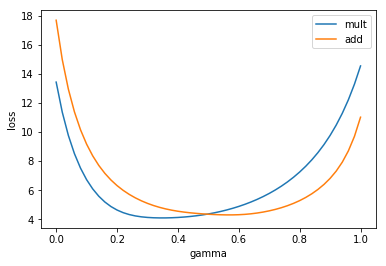

In [38]:
plt.plot(GAMMA, loss_mult, label = 'mult')
plt.plot(GAMMA, loss_add, label = 'add')
plt.xlabel("gamma")
plt.ylabel("loss")
plt.legend()

<h1 align="center">Conclusion </h1>
<h2>Simple Exponential Smoothing</h2>
    Minimal loss was reached when $\alpha$=0.24, but plot was not similar. It was similar when $\alpha$ was near 0.9. Accuracy with the optimal $\alpha$ was 93.92%, and with $\alpha$ = 0.9 accuracy was 91.99%.
<h2>Winters Exponential Smoothing</h2>
    Compare to SES WES is much better. Minimal loss was reached with following smoohing parameters: 
$$\alpha = 1.0 , \gamma = 0.48$$

Accuracy is much higher 98.09%.

<h2>Theil-Wage Exponential Smoothing</h2>
TWES optimal parameters are $$\alpha = 1.0, \beta = 0.02, \gamma = 0.56$$ again is better than SES and little bit better than WES due to accuracy = 98.42%.


<h2>Holt-Winters Multiplicative Exponential Smoothing</h2>
Optimal parameters are $$\alpha = 0.88, \beta = 0.62, \gamma = 0.36$$ HWMES was close to TWES with accuracy (98.35%).

<h2>Stability Comparision</h2>
Minimal loss for both models was:

        TWES Loss :4.236542586982742

        HWMES Loss :3.6600856416645207

Accuracies were close as well 98.42% and 98.35% for TWES and HWMES respectively. But from $\beta$ parameters plot we can say that HWMES is more stable than TWES, as $\alpha$ and $\gamma$ plots are very similar.